In [ ]:
#| default_exp express

# express
> A drop-in replacement for `plotly.express` that renames all labels from snake_case to Words.

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import plotly.express as px
from pdpatch.express import px

In [ ]:
#| export
from functools import partial, wraps
import inspect

import pandas as pd
from plotly import express
from plotly.graph_objects import Figure
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
from fastcore.all import *

from pdpatch.core import *
from pdpatch.case import *

## `set_template`
Sets `plotly` default template and updates its own doc string so you can always see your default template and options.

In [ ]:
#| export
def set_template(template_name):
    pio.templates.default = template_name
    set_template.__doc__  = str(pio.templates)
set_template.__doc__  = str(pio.templates)

In [ ]:
set_template('plotly')
test_eq(set_template.__doc__,
        "Templates configuration\n-----------------------\n    Default template: 'plotly'\n    Available templates:\n        ['ggplot2', 'seaborn', 'simple_white', 'plotly',\n         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',\n         'ygridoff', 'gridon', 'none']\n")

In [ ]:
set_template('seaborn')
test_eq(set_template.__doc__,
        "Templates configuration\n-----------------------\n    Default template: 'seaborn'\n    Available templates:\n        ['ggplot2', 'seaborn', 'simple_white', 'plotly',\n         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',\n         'ygridoff', 'gridon', 'none']\n")

## Fix seaborn template

The `seaborn` template sets the default line width to 0, making the invisible when using `add_vline` or `add_hline` methods.
It also sets `opacity` to `0.5`. We fix this by popping this keys and values from the seaborn template layout.

In [ ]:
df = pd.DataFrame({'time_foo_bar_xyz__s__': range(10), 'position__m__': range(10), 'speed__m/s__': 10*[1]})
fig = express.scatter(range(10), range(10))
fig.add_hline(4)
fig.add_vline(4)

In [ ]:
#| export
pio.templates['seaborn'].layout.shapedefaults.pop('line')
pio.templates['seaborn'].layout.shapedefaults.pop('opacity');

In [ ]:
df = pd.DataFrame({'time_foo_bar_xyz__s__': range(10), 'position__m__': range(10), 'speed__m/s__': 10*[1]})
fig = express.scatter(range(10), range(10))
fig.add_hline(4)
fig.add_vline(4)

## Default to colorblind palette

In [ ]:
#| export
cb = ['#%02x%02x%02x' % (int(x[0]*255), int(x[1]*255), int(x[2]*255)) for x in sns.color_palette('colorblind')]
for t in pio.templates: pio.templates[t]['layout']['colorway'] = cb

## Rename snake_case to Words

In [ ]:
#| export
def update_legend_and_yaxis(fun):
    @wraps(fun)
    def _inner(*args, **kwargs):
        fig = fun(*args, **kwargs)
        for t in fig.data:
            if hasattr(t, 'name'):
                t.update(name=px_labeler[t.name])
            if hasattr(t, 'legendgroup'):
                t.update(legendgroup=px_labeler[t.name])
            if hasattr(t, 'hovertemplate'):
                if not t.hovertemplate is None:
                    t.update(hovertemplate=t.hovertemplate.replace(t.name, px_labeler[t.name]))
        # some express functions like ecdf and histogram write their own yaxis text so we update it here
        if nested_attr(fig, 'layout.yaxis.title.text'):
            fig.update_layout(yaxis_title=px_labeler[fig.layout.yaxis.title.text])
        return fig
    return _inner

In [ ]:
#| export
class Express:
    '''Like `plotly.express` but defaults to labels=`px_labeler`'''
    def __getattr__(self, attr):
        fun = getattr(express, attr)
        docstr = fun.__doc__
        if hasattr(fun, '__call__'): 
            sig = inspect.signature(fun)
            if 'labels' in sig.parameters.keys():
                if attr=='imshow':
                    imshow_labeler = PxLabeler()
                    imshow_labeler['x'] = None
                    imshow_labeler['y'] = None
                    fun = partial(fun, labels=imshow_labeler)
                else:
                    fun = update_legend_and_yaxis(partial(fun, labels=px_labeler))
        fun.__doc__ = docstr
        return fun
    __dir__ = express.__dir__
px = Express()

In [ ]:
show_doc(Express)

---

[source](https://github.com/asappinc/pdpatch/tree/main/blob/main/pdpatch/express.py#L54){target="_blank" style="float:right; font-size:smaller"}

### Express

>      Express ()

Like `plotly.express` but defaults to labels=`px_labeler`

In [ ]:
acronyms.append('XYZ')

In [ ]:
df = pd.DataFrame({'time_foo_bar_xyz__s__': range(10), 'position__m__': range(10), 'speed__m/s__': 10*[1]})
px.scatter(df, x='time_foo_bar_xyz__s__', y='position__m__').show()

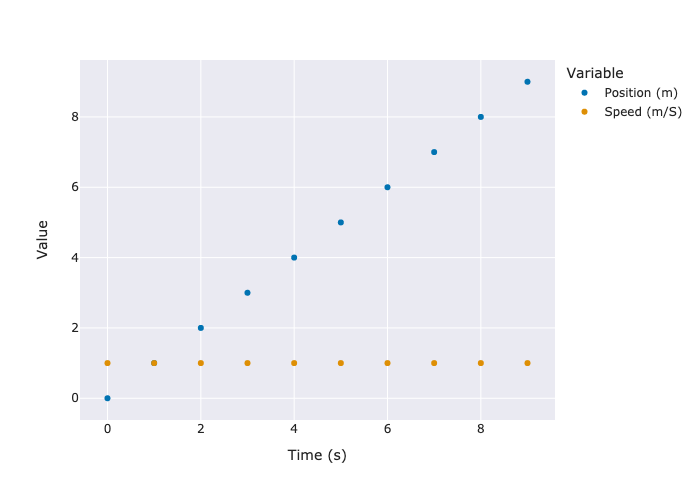

In [ ]:
df = pd.DataFrame({'time__s__': range(10), 'position__m__': range(10), 'speed__m/s__': 10*[1]})
fig = px.scatter(df,x='time__s__', y=['position__m__', 'speed__m/s__'])
fig.show(renderer="png")

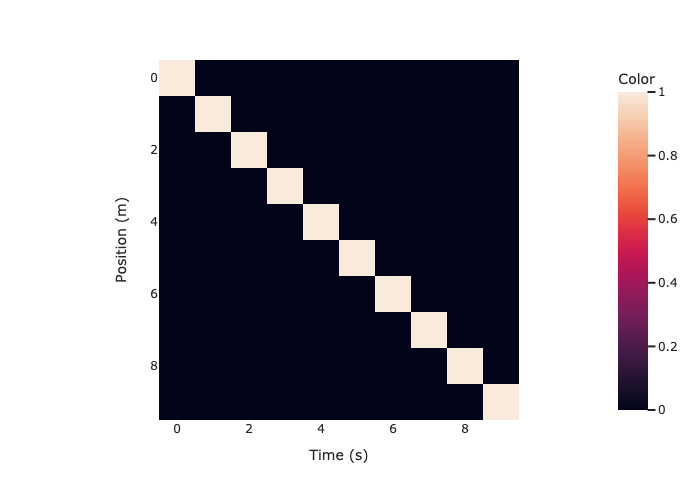

In [ ]:
df = pd.DataFrame({'time__s__': range(10), 'position__m__': range(10), 'speed__m/s__': 10*[1]})
px.imshow(df.crosstab(index='position__m__', column='time__s__')).show('png')

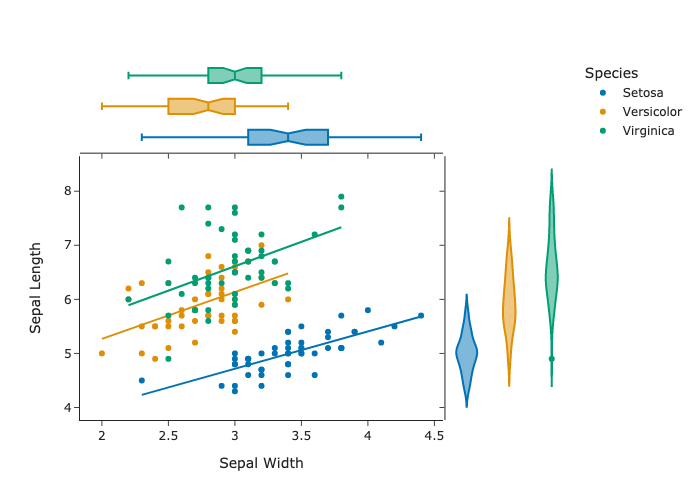

In [ ]:
df = px.data.iris()
fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show('png')

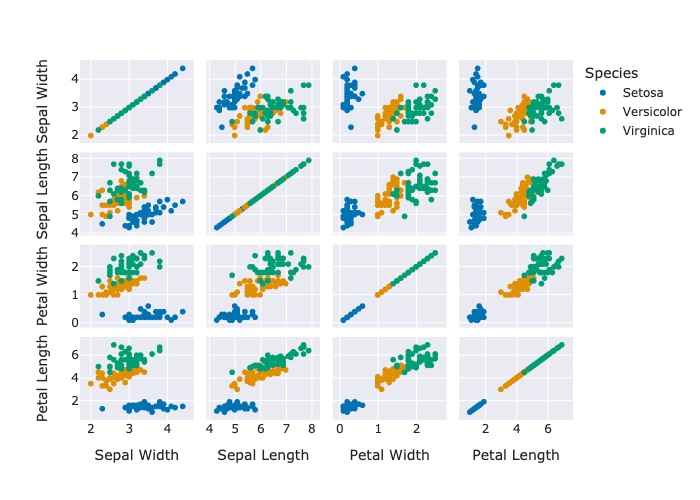

In [ ]:
df = px.data.iris()
fig = px.scatter_matrix(df, dimensions=["sepal_width", "sepal_length", "petal_width", "petal_length"], color="species")
fig.show('png')

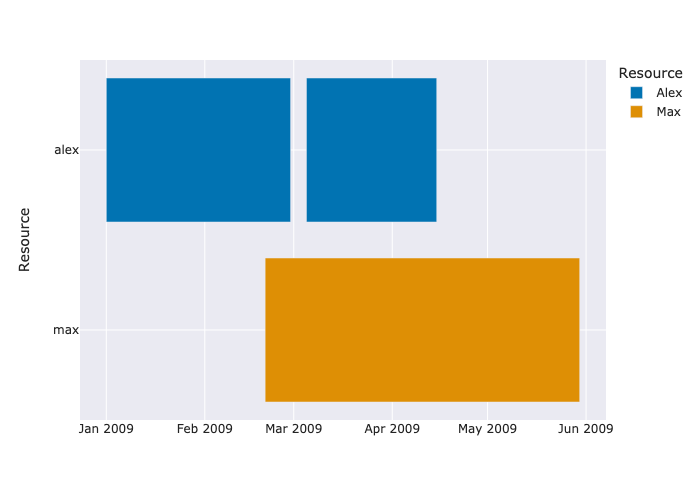

In [ ]:
df = pd.DataFrame([
    dict(task="Job A", start='2009-01-01', finish='2009-02-28', resource="alex"),
    dict(task="Job B", start='2009-03-05', finish='2009-04-15', resource="alex"),
    dict(task="Job C", start='2009-02-20', finish='2009-05-30', resource="max")
])

fig = px.timeline(df, x_start="start", x_end="finish", y="resource", color="resource")
fig.show('png')

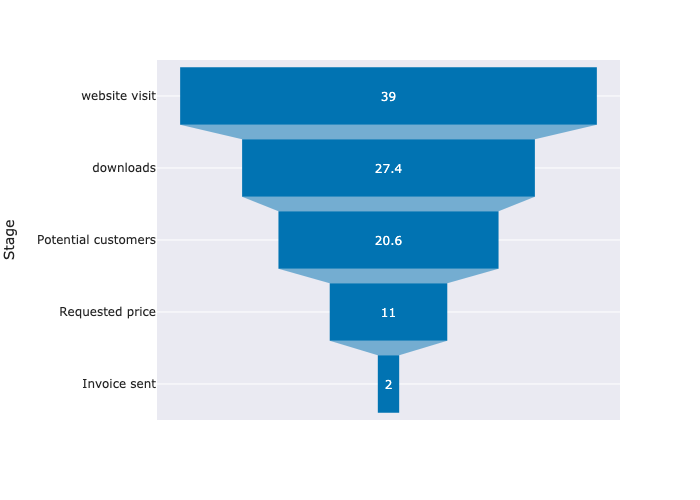

In [ ]:
data = dict(
    number=[39, 27.4, 20.6, 11, 2],
    stage=["website visit", "downloads", "Potential customers", "Requested price", "Invoice sent"])
fig = px.funnel(data, x='number', y='stage')
fig.show('png')

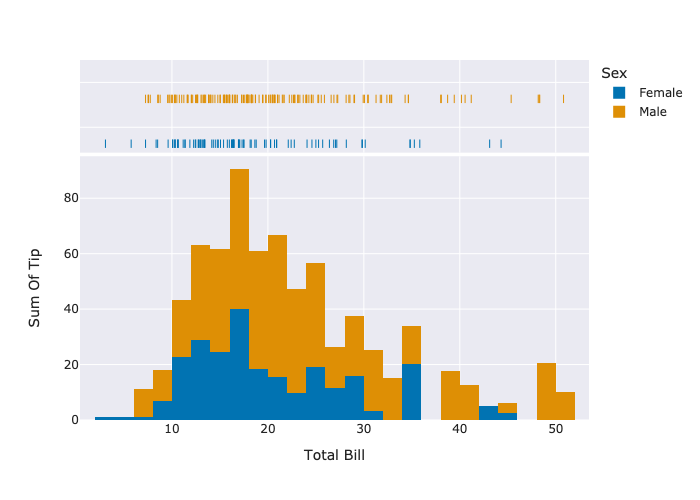

In [ ]:
df = px.data.tips()
fig = px.histogram(df, x="total_bill", y="tip", color="sex", marginal="rug", hover_data=df.columns)
fig.show('png')

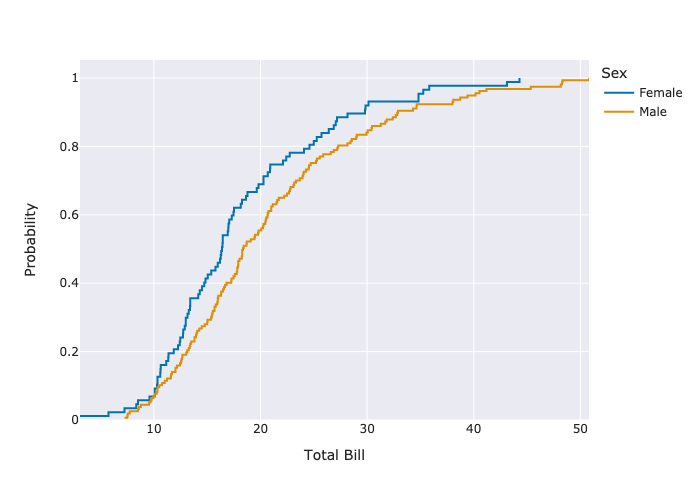

In [ ]:
df = px.data.tips()
fig = px.ecdf(df, x="total_bill", color="sex")
fig.show('png')

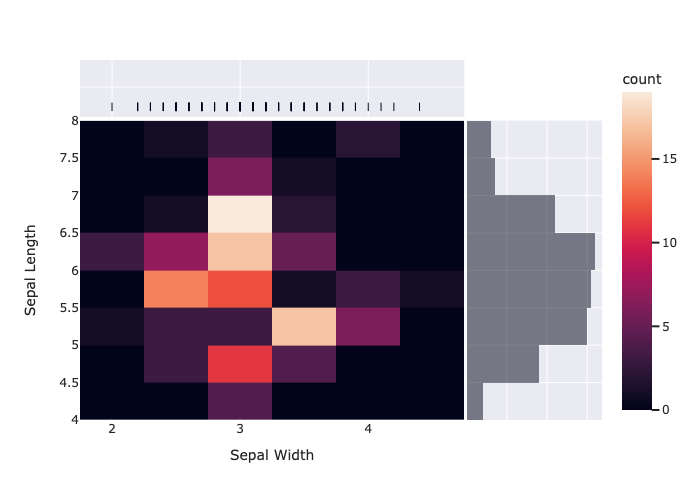

In [ ]:
df = px.data.iris()
fig = px.density_heatmap(df, x="sepal_width", y="sepal_length", marginal_x="rug", marginal_y="histogram")
fig.show('png')

## Altair like `__add__` method

In [ ]:
#| export
@patch
def __add__(self:Figure, other):
    color_discrete_sequence = ifnone(self.layout.colorway, pio.templates[pio.templates.default].layout.colorway)
    n_traces = len(self.data)
    if n_traces==1:
        self.data[0].name = self.layout.yaxis.title.text
        self.data[0].showlegend = True
        self.layout.yaxis.title.text = 'Value'
    if len(other.data)==1:
        other.data[0].name = other.layout.yaxis.title.text
    for i, trace in enumerate(other.data):
        trace.showlegend = True
        trace.update(marker_color=color_discrete_sequence[n_traces+i])
        self.add_trace(trace)
    return self

In [ ]:
df = pd.DataFrame({'time__s__': range(10), 'position__m__': [i**1.3 for i in range(10)], 'speed__m/s__': 10*[1]})
fig = px.scatter(df,x='time__s__', y=['position__m__', 'speed__m/s__'])
fig+px.scatter(df,x='time__s__', y='time__s__')

In [ ]:
# fig1 / fig2

In [ ]:
px.scatter(df,x='time__s__', y='position__m__')+px.scatter(df,x='time__s__', y='speed__m/s__')

In [ ]:
fig = px.scatter(df,x='time__s__', y='time__s__') + px.scatter(df,x='time__s__', y=['position__m__', 'speed__m/s__'])
fig

In [ ]:
#| export
@patch
def __or__(self:Figure, other):
    nr1 = len(self._grid_ref) if not self._grid_ref is None else 1
    nc1 = len(self._grid_ref[0]) if not self._grid_ref is None else 1
    nr2 = len(other._grid_ref) if not other._grid_ref is None else 1
    nc2 = len(other._grid_ref[0]) if not other._grid_ref is None else 1
    n_cols = nc1+nc2
    assert nr2 == nr1
    n_rows = nr1
    fig = make_subplots(rows=n_rows, cols=n_cols)
    for trace in self.data:
        index = trace.xaxis.replace('x', '')
        if index=='': index='1'
        index = int(index)-1
        row = index // nc1 + 1
        col = index % nc1 + 1
        fig.add_trace(trace, row=row, col=col)
    for trace in other.data:
        index = trace.xaxis.replace('x', '')
        if index=='': index='1'
        index = int(index)-1
        row = index // nc2 + 1
        col = nc1 + index % nc2 + 1
        #print('col = nc1 + index % n_cols + 1')
        #print(f' col={col} nc1={nc1}, index={index}, n_cols={n_cols}')
        fig.add_trace(trace, row=row, col=col)
    return fig

In [ ]:
fig = px.scatter(df,x='time__s__', y='time__s__') | px.scatter(df,x='time__s__', y=['position__m__', 'speed__m/s__'])
fig

In [ ]:
#| export
@patch
def __truediv__(self:Figure, other):
    nr1 = len(self._grid_ref) if not self._grid_ref is None else 1
    nc1 = len(self._grid_ref[0]) if not self._grid_ref is None else 1
    nr2 = len(other._grid_ref) if not other._grid_ref is None else 1
    nc2 = len(other._grid_ref[0]) if not other._grid_ref is None else 1
    n_rows = nr1 + nr2
    assert nc2 == nc1
    n_cols = nc1
    fig = make_subplots(rows=n_rows, cols=n_cols)
    for trace in self.data:
        index = trace.xaxis.replace('x', '')
        if index=='': index='1'
        index = int(index)-1
        row = index // nc1 + 1
        col = index % nc1 + 1
        fig.add_trace(trace, row=row, col=col)
    for trace in other.data:
        index = trace.xaxis.replace('x', '')
        if index=='': index='1'
        index = int(index)-1
        row = nr1 + index // nc2 + 1
        col = index % nc2 + 1
        fig.add_trace(trace, row=row, col=col)
    return fig

In [ ]:
fig = px.scatter(df,x='time__s__', y='time__s__') / px.scatter(df,x='time__s__', y=['position__m__', 'speed__m/s__'])
fig

In [ ]:
fig = px.scatter(df,x='time__s__', y='time__s__') / px.scatter(df,x='time__s__', y=['position__m__', 'speed__m/s__'])
fig | fig

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev import nbdev_export; nbdev_export()